In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("data")

files = {
    "warm": DATA_DIR / "k6_lambda_warm.json",
    "mixed": DATA_DIR / "k6_lambda_mixed.json",
    "cold": DATA_DIR / "k6_lambda_cold.json",
}

files

{'warm': PosixPath('data/k6_lambda_warm.json'),
 'mixed': PosixPath('data/k6_lambda_mixed.json'),
 'cold': PosixPath('data/k6_lambda_cold.json')}

In [16]:
def load_k6_latencies(path):
    vals = []
    with open(path) as f:
        for line in f:
            if not line.strip():
                continue
            obj = json.loads(line)
            # check top-level 'metric' key
            if obj.get("type") == "Point" and obj.get("metric") == "http_req_duration":
                vals.append(obj["data"]["value"])
    return vals
    data = {name: load_k6_latencies(path) for name, path in files.items()}
for k, v in data.items():
    print(f"{k}: {len(v)} samples")



warm: 150 samples
mixed: 150 samples
cold: 10 samples


In [17]:
import numpy as np
import pandas as pd

def summary(values):
    if not values:
        return {}
    vs = pd.Series(values)
    return {
        "count": len(vs),
        "avg_ms": vs.mean(),
        "p50_ms": np.percentile(vs, 50),
        "p90_ms": np.percentile(vs, 90),
        "p95_ms": np.percentile(vs, 95),
        "max_ms": vs.max(),
    }

df = pd.DataFrame({k: summary(v) for k, v in data.items()}).T
df.round(2)


,count,avg_ms,p50_ms,p90_ms,p95_ms,max_ms
warm,150.0,86.23,69.27,90.68,290.81,330.20
mixed,150.0,73.00,69.82,87.25,94.89,150.75
cold,10.0,104.56,83.80,119.81,200.62,281.42


In [4]:
cloudwatch = pd.DataFrame([{
    "avg_ms": 7.2,
    "p50_ms": 6.7,
    "p95_ms": 9.3,
    "billed_ms": 100.0,
    "source": "cloudwatch"
}])

cloudwatch


,avg_ms,p50_ms,p95_ms,billed_ms,source
0,7.2,6.7,9.3,100.0,cloudwatch


In [12]:
# rebuild data dict from df so plotting uses real values
data = {
    "warm": load_k6_linejson(files["warm"]),
    "mixed": load_k6_linejson(files["mixed"]),
    "cold": load_k6_linejson(files["cold"]),
}

for k, v in data.items():
    print(k, len(v))


warm 150
mixed 150
cold 10


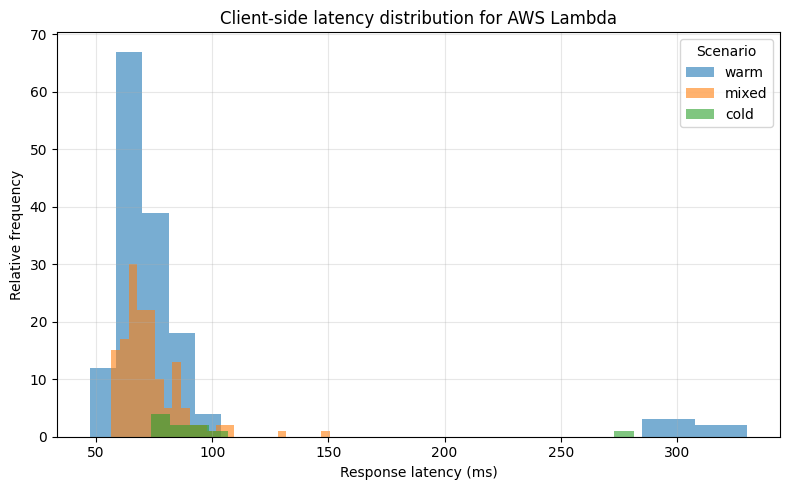

In [13]:
plt.figure(figsize=(8,5))
for name, vals in data.items():
    if vals:
        plt.hist(vals, bins=25, alpha=0.6, label=name)
plt.xlabel("Response latency (ms)")
plt.ylabel("Relative frequency")
plt.title("Client-side latency distribution for AWS Lambda")
plt.legend(title="Scenario")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [14]:
import json, os
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("data")
files = {
    "warm": DATA_DIR / "k6_lambda_warm.json",
    "mixed": DATA_DIR / "k6_lambda_mixed.json",
    "cold": DATA_DIR / "k6_lambda_cold.json",
}

#print("== Files I see in ./data ==")
#print(os.listdir(DATA_DIR))

def load_k6_linejson(path: Path):
    """Load k6 newline JSON (your format) and return all http_req_duration values."""
    vals = []
    if not path.exists():
        return vals
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            # IMPORTANT: in your files, metric is TOP-LEVEL
            if obj.get("type") == "Point" and obj.get("metric") == "http_req_duration":
                vals.append(float(obj["data"]["value"]))
    return vals

rows = []
for name, path in files.items():
    vals = load_k6_linejson(path)
    if not vals:
        print(f"[warn] no http_req_duration found in {path}")
        rows.append({
            "scenario": name,
            "count": 0,
            "avg_ms": np.nan,
            "p50_ms": np.nan,
            "p90_ms": np.nan,
            "p95_ms": np.nan,
            "max_ms": np.nan,
        })
    else:
        s = pd.Series(vals)
        rows.append({
            "scenario": name,
            "count": len(s),
            "avg_ms": s.mean(),
            "p50_ms": np.percentile(s, 50),
            "p90_ms": np.percentile(s, 90),
            "p95_ms": np.percentile(s, 95),
            "max_ms": s.max(),
        })

df = pd.DataFrame(rows).set_index("scenario")
df


,count,avg_ms,p50_ms,p90_ms,p95_ms,max_ms
scenario,,,,,,
warm,150,86.227313,69.2700,90.6785,290.81455,330.202
mixed,150,73.000307,69.8175,87.2521,94.89110,150.753
cold,10,104.557500,83.8025,119.8142,200.61710,281.420


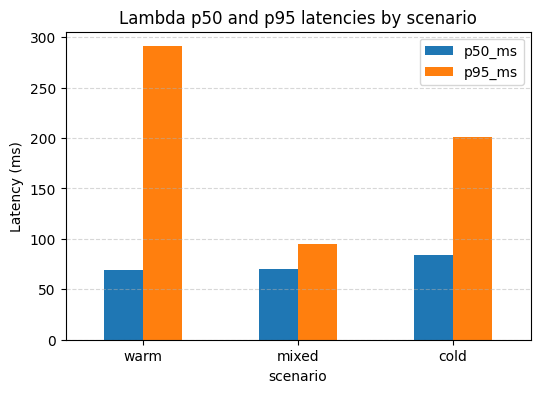

In [8]:
ax = df[["p50_ms", "p95_ms"]].plot.bar(rot=0, figsize=(6,4))
ax.set_ylabel("Latency (ms)")
ax.set_title("Lambda p50 and p95 latencies by scenario")
ax.grid(axis="y", linestyle="--", alpha=0.5)


In [9]:
memory_gb = 128/1024
price_gb_s = 0.0000166667
price_req = 0.0000002

billed_ms = cloudwatch.loc[0, "billed_ms"]
billed_s = billed_ms / 1000
cost_1000 = billed_s * memory_gb * price_gb_s * 1000 + 1000 * price_req
print(f"Estimated cost per 1000 req: ${cost_1000:.6f}")


Estimated cost per 1000 req: $0.000408


In [10]:
df.to_csv(DATA_DIR / "lambda_summary.csv", index_label="scenario")
df

,count,avg_ms,p50_ms,p90_ms,p95_ms,max_ms
scenario,,,,,,
warm,150,86.227313,69.2700,90.6785,290.81455,330.202
mixed,150,73.000307,69.8175,87.2521,94.89110,150.753
cold,10,104.557500,83.8025,119.8142,200.61710,281.420
